<a href="https://colab.research.google.com/github/Qiaochu-Zhang/C-_Grades_with_Hash_Table/blob/main/densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install torch torchvision
!pip install opencv-python

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Total dataset size: 743
Training+Validation set size: 668
Test set size: 75


100%|██████████| 30.8M/30.8M [00:00<00:00, 175MB/s]
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(



Fold 1
--------------------------------
Epoch [1/5], Loss: 0.5294
Validation Accuracy: 75.37%
Epoch [2/5], Loss: 0.2060
Validation Accuracy: 81.34%
Epoch [3/5], Loss: 0.1181
Validation Accuracy: 88.06%
Epoch [4/5], Loss: 0.0650
Validation Accuracy: 82.84%
Epoch [5/5], Loss: 0.0335
Validation Accuracy: 82.09%


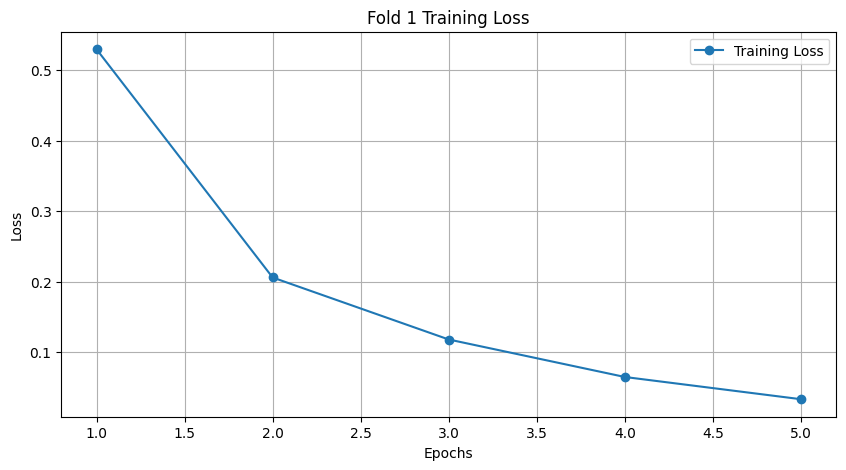

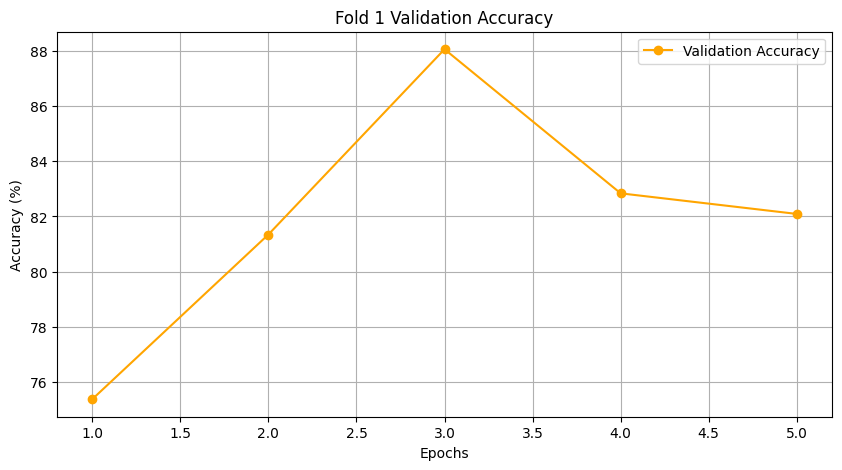

Best Validation Accuracy for Fold 1: 88.06%

Fold 2
--------------------------------
Epoch [1/5], Loss: 0.5477
Validation Accuracy: 80.60%
Epoch [2/5], Loss: 0.2065
Validation Accuracy: 79.85%
Epoch [3/5], Loss: 0.0752
Validation Accuracy: 91.79%
Epoch [4/5], Loss: 0.0285
Validation Accuracy: 91.79%
Epoch [5/5], Loss: 0.0227
Validation Accuracy: 91.79%


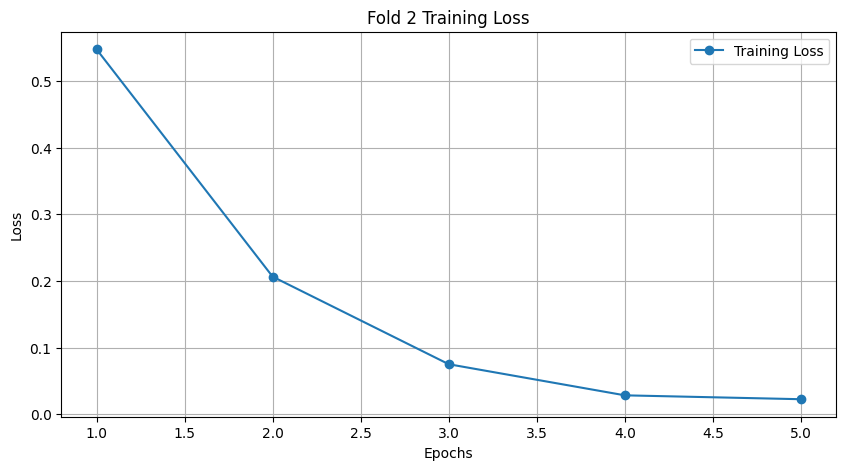

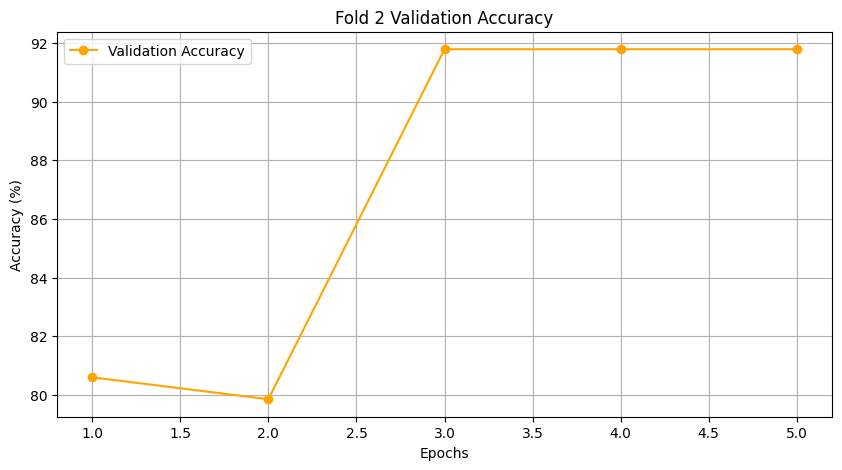

Best Validation Accuracy for Fold 2: 91.79%

Fold 3
--------------------------------
Epoch [1/5], Loss: 0.5412
Validation Accuracy: 83.58%
Epoch [2/5], Loss: 0.2435
Validation Accuracy: 86.57%
Epoch [3/5], Loss: 0.1017
Validation Accuracy: 93.28%
Epoch [4/5], Loss: 0.0365
Validation Accuracy: 94.03%
Epoch [5/5], Loss: 0.0330
Validation Accuracy: 91.79%


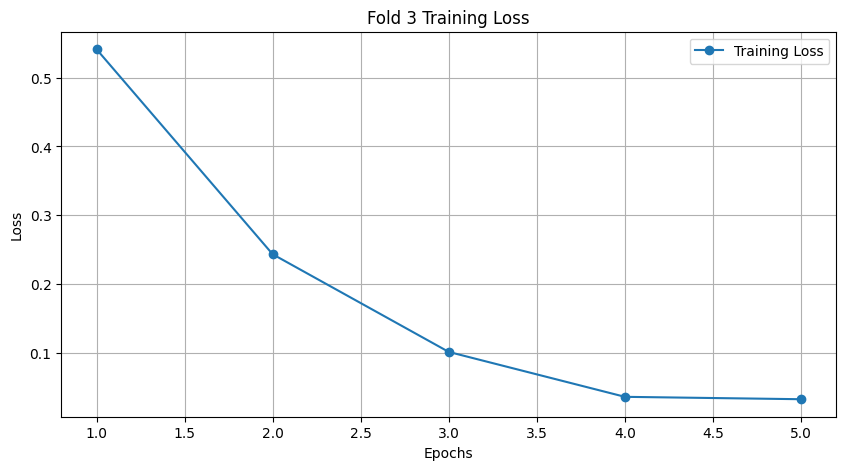

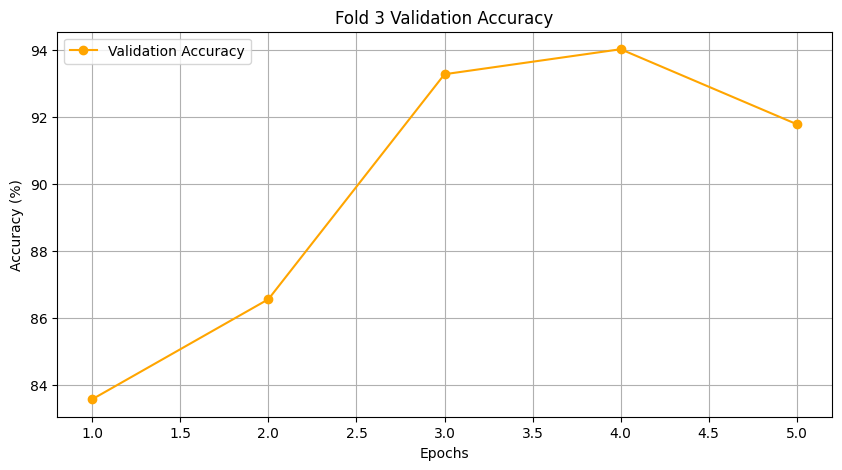

Best Validation Accuracy for Fold 3: 94.03%

Fold 4
--------------------------------
Epoch [1/5], Loss: 0.5457
Validation Accuracy: 81.95%
Epoch [2/5], Loss: 0.2095
Validation Accuracy: 89.47%
Epoch [3/5], Loss: 0.0787
Validation Accuracy: 90.98%
Epoch [4/5], Loss: 0.0424
Validation Accuracy: 85.71%
Epoch [5/5], Loss: 0.0301
Validation Accuracy: 89.47%


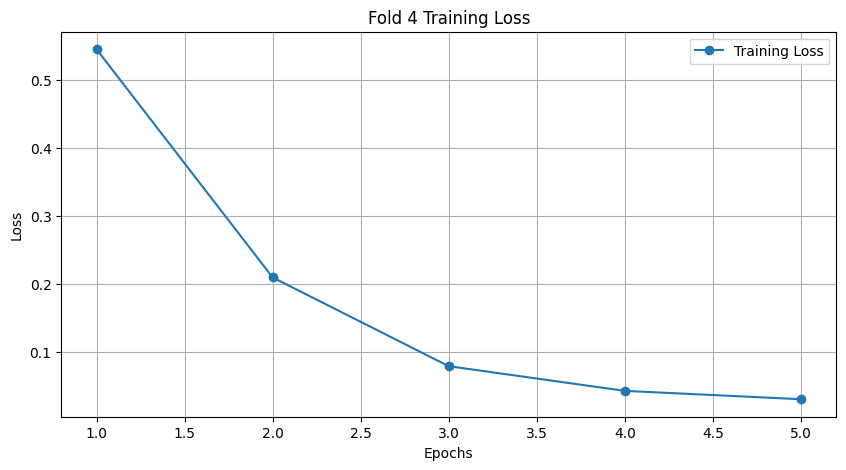

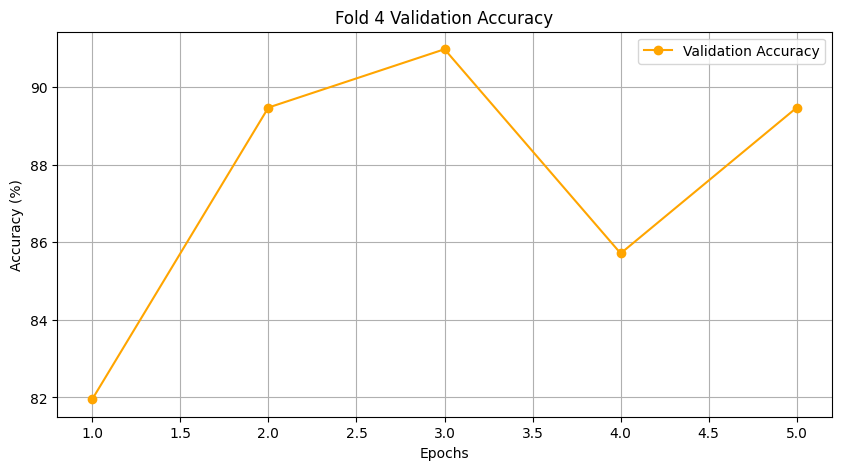

Best Validation Accuracy for Fold 4: 90.98%

Fold 5
--------------------------------
Epoch [1/5], Loss: 0.5700
Validation Accuracy: 80.45%
Epoch [2/5], Loss: 0.2136
Validation Accuracy: 84.96%
Epoch [3/5], Loss: 0.0803
Validation Accuracy: 91.73%
Epoch [4/5], Loss: 0.0518
Validation Accuracy: 89.47%
Epoch [5/5], Loss: 0.0371
Validation Accuracy: 89.47%


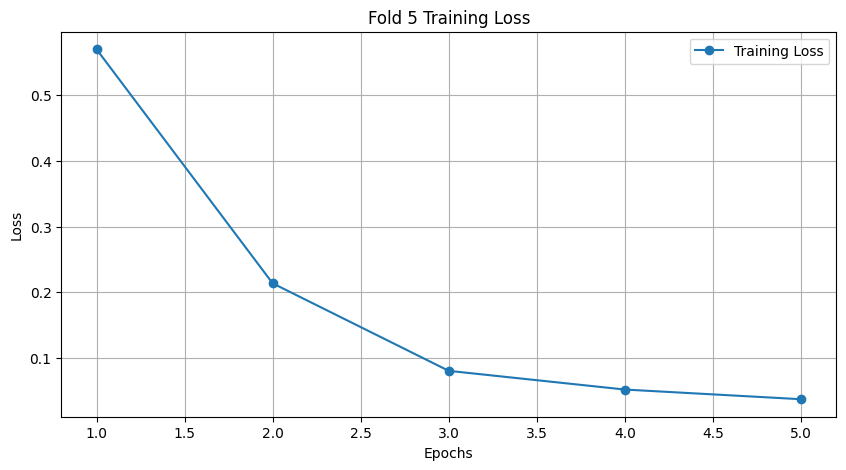

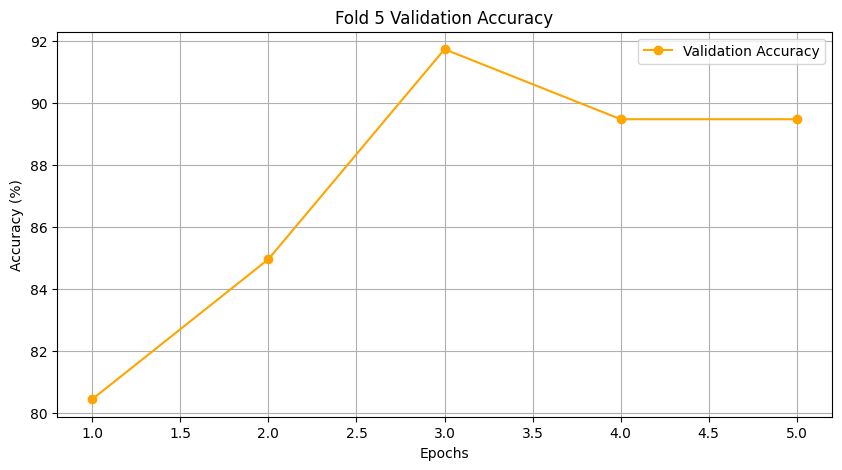

Best Validation Accuracy for Fold 5: 91.73%

Test Accuracy: 90.67%


In [7]:
!pip install timm  # PyTorch Image Models库，包含Xception模型

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import cv2
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import KFold, train_test_split
import random
import matplotlib.pyplot as plt
import timm  # PyTorch Image Models库

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 自定义数据集类，提取噪声作为输入
class NoiseDataset(Dataset):
    def __init__(self, image_folder, label):
        self.image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
        self.labels = [label] * len(self.image_paths)
        # 修改transforms.Resize为224x224
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])  # 使用ImageNet的均值和标准差
        ])

    def extract_noise(self, image_path):
        """提取图片的噪声特征"""
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            # 如果无法读取图像，返回None
            return None
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        noise = cv2.absdiff(img, blurred)  # 计算噪声图
        return Image.fromarray(noise)  # 转换为 PIL 格式

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 提取噪声图像
        noise_image = self.extract_noise(self.image_paths[idx])
        if noise_image is None:
            # 如果无法读取图像，则跳过该样本
            return self.__getitem__((idx + 1) % len(self.image_paths))
        img_tensor = self.transform(noise_image)
        label = self.labels[idx]
        return img_tensor, label

# 定义数据集路径
real_images_path = '/content/drive/MyDrive/Real'  # 请根据您的实际路径调整
ai_images_path = '/content/drive/MyDrive/fake'    # 请根据您的实际路径调整

# 加载真实图片和AI生成的图片数据集
real_dataset = NoiseDataset(real_images_path, label=0)
ai_dataset = NoiseDataset(ai_images_path, label=1)

# 合并数据集
full_dataset = real_dataset + ai_dataset

# 获取所有样本的标签
labels = [label for _, label in full_dataset]

# 划分测试集（约10%）
test_size = 0.1
train_val_indices, test_indices = train_test_split(
    range(len(full_dataset)),
    test_size=test_size,
    stratify=labels,
    random_state=42
)

# 创建训练+验证集和测试集
train_val_dataset = Subset(full_dataset, train_val_indices)
test_dataset = Subset(full_dataset, test_indices)

print(f"Total dataset size: {len(full_dataset)}")
print(f"Training+Validation set size: {len(train_val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

from torchvision import models

# 加载预训练的DenseNet模型（以DenseNet-121为例）
model = models.densenet121(pretrained=True)

# 修改第一层卷积层，适应单通道输入
original_conv0 = model.features.conv0
model.features.conv0 = nn.Conv2d(
    in_channels=1,
    out_channels=original_conv0.out_channels,
    kernel_size=original_conv0.kernel_size,
    stride=original_conv0.stride,
    padding=original_conv0.padding,
    bias=original_conv0.bias is not None
)
with torch.no_grad():
    model.features.conv0.weight = nn.Parameter(original_conv0.weight.sum(dim=1, keepdim=True))

# 修改最后的全连接层，适应2个类别
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)

# 将模型移动到设备上
model = model.to(device)


# 定义K折交叉验证
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 用于保存最佳模型的参数
best_model_wts = None
best_acc = 0.0

# 在训练+验证集上进行K折交叉验证
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_val_indices)):
    print(f'\nFold {fold + 1}')
    print('--------------------------------')

    # 在fold开始时，初始化列表用于保存训练损失和验证准确率
    train_losses = []
    val_accuracies = []

    # 获取当前折的训练和验证索引
    train_sub_ids = [train_val_indices[i] for i in train_ids]
    val_sub_ids = [train_val_indices[i] for i in val_ids]

    # 定义训练和验证数据集
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_sub_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_sub_ids)

    # 定义数据加载器
    train_loader = torch.utils.data.DataLoader(
        full_dataset,
        batch_size=16, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(
        full_dataset,
        batch_size=16, sampler=val_subsampler)

    # 重新初始化模型和优化器
    model = timm.create_model('xception', pretrained=True)

    # 修改第一层卷积层，适应单通道输入
    original_conv1 = model.conv1
    model.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias is not None
    )
    with torch.no_grad():
        model.conv1.weight = nn.Parameter(original_conv1.weight.sum(dim=1, keepdim=True))

    # 修改最后的全连接层，适应2个类别
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    # 将模型移动到设备上
    model = model.to(device)

    # 定义优化器
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 5  # 可以根据需要调整

    # 开始训练
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # 记录训练损失
        train_losses.append(avg_loss)

        # 在验证集上评估模型
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

        # 记录验证准确率
        val_accuracies.append(accuracy)

    # 绘制训练损失曲线
    plt.figure(figsize=(10, 5))
    plt.title(f'Fold {fold + 1} Training Loss')
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 绘制验证准确率曲线
    plt.figure(figsize=(10, 5))
    plt.title(f'Fold {fold + 1} Validation Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 保存结果
    fold_best_acc = max(val_accuracies)
    print(f'Best Validation Accuracy for Fold {fold + 1}: {fold_best_acc:.2f}%')

    # 如果当前折的最佳准确率高于全局最佳准确率，保存模型参数
    if fold_best_acc > best_acc:
        best_acc = fold_best_acc
        best_model_wts = model.state_dict()

# 加载最佳模型参数
model.load_state_dict(best_model_wts)

# 在测试集上评估模型
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
test_accuracy = 100 * correct / total
print(f'\nTest Accuracy: {test_accuracy:.2f}%')
